In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# save current file's folder in variable to use in other cells
import os
from pathlib import Path

cwd = Path.cwd()
print(cwd)

/Users/ivang/PycharmProjects/pythonProject/notebooks/evaluation


In [3]:
from dotenv import load_dotenv

load_dotenv()

project_root = os.getenv('PROJECT_ROOT')
print(project_root)
path = os.path.join(project_root)
os.chdir(os.path.join(path, "notebooks/evaluation"))
print(os.getcwd())

/Users/ivang/PycharmProjects/pythonProject/
/Users/ivang/PycharmProjects/pythonProject/notebooks/evaluation


# Prepare data for OCTIS

In [4]:
import numpy as np

In [5]:
from src.evaluation import Trainer, DataLoader

[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
%%time
# dataloader = DataLoader(dataset="trump").prepare_docs(save="trump.txt").preprocess_octis(output_folder="trump")
dataloader = DataLoader(dataset="openml").prepare_docs(save=os.path.join(cwd, "openml.txt"))
dropped_indices = dataloader.dropped_indices
dataloader.preprocess_octis(output_folder=os.path.join(cwd, "openml"))

Dropped indices: [5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282]


100%|██████████| 5274/5274 [00:00<00:00, 83241.49it/s]


created vocab
35046
words filtering done
CPU times: user 860 ms, sys: 45.9 ms, total: 906 ms
Wall time: 1.01 s


In [7]:
dropped_indices

[5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282]

In [8]:
import pandas as pd

# df = pd.read_csv("openml/corpus.tsv", sep="\t")
df = pd.read_csv(os.path.join(cwd, "openml/corpus.tsv"), sep="\t", header=None, keep_default_na=False)
# print df where NoneType
# print(df[df.isnull().any(axis=1)])
df

,0,1
0,Anneal Study Study Study Study Study Study Stu...,train
1,End-Game King Rook versus King Pawn on This da...,train
2,This dataset pertains to the final settlements...,train
3,Arrhythmia Machine Sport Cardiac Arrhythmia Da...,train
4,Letter Image Recognition Data The objective of...,train
...,...,...
5269,Credit Score Classification Person Credit Rela...,train
5270,The One Thirty Two dataset has been tagged wit...,train
5271,Login Data for Cybersecurity Events Login Data...,train
5272,Dataset User Ravi Dummy Data The event time wh...,train


In [9]:
from sentence_transformers import SentenceTransformer

# Prepare data
dataset_name, custom = "openml", True
data_loader = DataLoader(dataset_name)
_, timestamps, _ = data_loader.load_docs()
dataset = data_loader.load_octis(custom)
data = [" ".join(words) for words in dataset.get_corpus()]

Dropped indices: [5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282]


In [10]:
# embedding_model = SentenceTransformer("all-mpnet-base-v2")
embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
# embeddings = embedding_model.encode(data, show_progress_bar=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# save embeddings to mpnet_embeddings.npy
# np.save('mpnet_embeddings.npy', embeddings)
# load 
# embeddings = np.load('mpnet_embeddings.npy')

embeddings = np.load('../embeddings_prompts.npy')
# if embeddings have been previously saved without dropping indices, drop them
embeddings = np.delete(embeddings, dropped_indices, axis=0)

In [14]:
embeddings

array([[-6.0323005 ,  0.463492  ,  4.01652   , ..., 10.593845  ,
         1.414038  ,  1.8073224 ],
       [-0.64597124,  0.46698   ,  8.939073  , ...,  3.1171947 ,
         3.9019103 , -0.639417  ],
       [ 0.09761869,  2.8749747 ,  5.3688436 , ...,  7.345148  ,
         0.6610787 , -4.397552  ],
       ...,
       [ 1.1464643 , -1.2929353 ,  8.681696  , ...,  8.333253  ,
        -2.3078835 ,  5.121531  ],
       [-0.3953529 ,  1.5415511 ,  4.850828  , ..., 10.074807  ,
        -6.213024  ,  2.1345417 ],
       [-2.1108336 , -1.0013711 ,  3.1051905 , ...,  8.141632  ,
        -1.7848598 ,  7.401485  ]], dtype=float32)

# Bayesian optimization of parameters

In [16]:
import spacy
import re
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000


def preprocess_text(text):
    # Replace underscores and dashes with spaces
    # text = text.replace('_', ' ').replace('-', ' ')
    # Insert a space before all caps (but not at the start of the string)
    # text = re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])', ' ', text)
    # Remove many whitespaces
    text = re.sub(r'\s+', ' ', text)

    # remove numbers
    # text = re.sub(r'\d+', '', text)

    return text


def safe_chunker(text, chunk_size=1000000):
    # Safely chunk the text by trying not to cut off sentences mid-way
    start = 0
    while start < len(text):
        end = start + chunk_size
        if end < len(text):
            # Move the end to the end of a sentence, if possible
            while end < len(text) and text[end] not in '.!?':
                end += 1
            end += 1  # Include the punctuation mark

            # If the adjusted end is still larger than chunk_size, cut at chunk_size
            if end - start > chunk_size:
                end = start + chunk_size
                # Move the end back to the last space to avoid cutting words
                while end > start and text[end] not in ' .!?':
                    end -= 1

        yield text[start:end].strip()
        start = end


def spacy_lemmatizer(text):
    text = preprocess_text(text)
    processed_tokens = []

    for chunk in safe_chunker(text):
        doc = nlp(chunk)
        lemmas = [
            token.lemma_.lower() for token in doc
            if not token.is_punct and not token.is_stop
        ]
        processed_tokens.extend(lemmas)

    return processed_tokens

In [17]:
from src.octis.bertopic import BERTopic
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from src.evaluation.weighted_metric import WeightedMetric

topk = 10
objective_metric = WeightedMetric(texts=dataset.get_corpus(), topk=topk)
objective_metric

In [41]:
npmi = Coherence(texts=dataset.get_corpus(), topk=topk)

In [42]:
diversity = TopicDiversity(topk=topk)

In [45]:
search_space = {
    # "embedding_model": Categorical(["all-mpnet-base-v2"]),
    # "embedding_model": Categorical(["Salesforce/SFR-Embedding-Mistral"]),
    # "nr_topics": Integer(10, 1000),
    "min_topic_size": Integer(2, 40),
    "ctfidf_reduce_frequent_words": Categorical({'True', 'False'}),
    "umap_n_neighbors": Integer(2, 100),
    "umap_n_components": Integer(2, 10),
    "umap_min_dist": Real(0.0, 0.2),
    "umap_metric": Categorical(['cosine', 'euclidean']),
    "hdbscan_min_cluster_size": Integer(2, 50),
    "hdbscan_metric": Categorical(['euclidean']),
    "hdbscan_cluster_selection_method": Categorical(['eom']),
    "vectorizer_ngram_range": Categorical({'(1, 1)', '(1, 2)'}),
    "vectorizer_stop_words": Categorical(["english"]),
    # "vectorizer_tokenizer": Categorical({'True', 'False'}),
    "vectorizer_tokenizer": Categorical({'False'}),
}

# Set optimization parameters
optimization_runs = 200
model_runs = 3
optimizer = Optimizer()

# Run optimization
optimization_result = optimizer.optimize(
    model=BERTopic(embeddings=embeddings, embedding_model=embedding_model, vectorizer_tokenizer=spacy_lemmatizer, topk=topk, verbose=False),
    dataset=dataset,
    metric=objective_metric,
    search_space=search_space,
    number_of_call=optimization_runs,
    model_runs=model_runs,
    save_models=True,
    extra_metrics=[npmi, diversity],
    save_path='./results/optimizer'
)

Current call:  0
Current params:  {'ctfidf_reduce_frequent_words': 'True', 'hdbscan_cluster_selection_method': 'eom', 'hdbscan_metric': 'euclidean', 'hdbscan_min_cluster_size': 21, 'min_topic_size': 24, 'umap_metric': 'euclidean', 'umap_min_dist': 0.03609605947799055, 'umap_n_components': 8, 'umap_n_neighbors': 85, 'vectorizer_ngram_range': '(1, 1)', 'vectorizer_stop_words': 'english', 'vectorizer_tokenizer': 'False'}
brah [['kinase', 'receptor', 'regulation', 'qsar', 'protein', 'molecular', 'chembl', 'fingerprints', 'coupled', 'molecule'], ['equals', 'columns', 'classes', 'seed', 'uniformly', 'random', 'subsampling', 'maximum', 'arguments', 'indices'], ['binarized', 'nominal', 'lower', 'study', 'oz', 'classifying', 'numeric', 'instances', 'life', 'Anneal'], ['bid', 'ask', 'price', 'Anneal', 'time', 'close', 'recorded', 'historical', 'lowest', 'hourly'], ['bayesian', 'network', 'printer', 'nodes', 'markov', 'blanket', 'degree', 'bnlearn', 'average', 'discrete'], ['tcp', 'tls', 'disconn

IndexError: list index out of range

In [ ]:
optimization_result.save_to_csv("./results/optimizer/results_BERTopic_salesforce2.csv")

In [22]:
import json

res = json.load(open("./results/optimizer/result.json", 'r'))
res

{'dataset_name': 'dataset_name',
 'dataset_path': 'openml',
 'is_cached': False,
 'kernel': '1**2 * Matern(length_scale=1, nu=1.5)',
 'acq_func': 'LCB',
 'surrogate_model': 'RF',
 'optimization_type': 'Maximize',
 'model_runs': 3,
 'save_models': True,
 'save_step': 1,
 'save_name': 'result',
 'save_path': './results/optimizer/',
 'early_stop': False,
 'early_step': 5,
 'plot_model': False,
 'plot_best_seen': False,
 'plot_name': 'B0_plot',
 'log_scale_plot': False,
 'search_space': {'min_topic_size': ['Integer', [2, 40], 'uniform'],
  'ctfidf_reduce_frequent_words': ['Categorical', ['True', 'False'], None],
  'umap_n_neighbors': ['Integer', [2, 25], 'uniform'],
  'umap_n_components': ['Integer', [2, 10], 'uniform'],
  'umap_min_dist': ['Real', [0.0, 0.2], 'uniform'],
  'umap_metric': ['Categorical', ['cosine', 'euclidean'], None],
  'hdbscan_min_cluster_size': ['Integer', [2, 20], 'uniform'],
  'hdbscan_metric': ['Categorical', ['euclidean'], None],
  'hdbscan_cluster_selection_method

In [19]:
df = pd.read_csv("./results/optimizer/results_BERTopic_salesforce.csv")
df

,dataset,surrogate model,acquisition function,num_iteration,time,Median(model_runs),Mean(model_runs),Standard_Deviation(model_runs),ctfidf_reduce_frequent_words,hdbscan_cluster_selection_method,...,min_topic_size,umap_metric,umap_min_dist,umap_n_components,umap_n_neighbors,vectorizer_ngram_range,vectorizer_stop_words,vectorizer_tokenizer,Coherence(not optimized),Topic diversity(not optimized)
0,dataset_name,RF,LCB,0,63.835365,-0.695818,-0.697749,0.179495,True,eom,...,24,euclidean,0.036096,8,21,"(1, 2)",english,False,0.193374,0.414356
1,dataset_name,RF,LCB,1,35.796545,-0.452360,-0.453866,0.292092,False,eom,...,28,euclidean,0.177497,8,8,"(1, 1)",english,False,-0.050769,0.850877
2,dataset_name,RF,LCB,2,38.531638,-0.617179,-0.605191,0.047126,True,eom,...,5,euclidean,0.021192,3,7,"(1, 2)",english,False,0.048423,0.562162
3,dataset_name,RF,LCB,3,63.005083,-0.735217,-0.738045,0.045606,False,eom,...,24,euclidean,0.064685,5,8,"(1, 2)",english,False,-0.000618,0.458654
4,dataset_name,RF,LCB,4,42.273088,-0.560961,-0.549265,0.164734,False,eom,...,30,euclidean,0.070399,9,23,"(1, 2)",english,False,-0.017676,0.686207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,dataset_name,RF,LCB,295,33.189454,-0.427730,-0.425662,0.303084,True,eom,...,10,euclidean,0.188028,7,21,"(1, 1)",english,False,-0.034546,0.886957
296,dataset_name,RF,LCB,296,38.462751,-0.425477,-0.426370,0.284350,False,eom,...,15,cosine,0.178695,3,25,"(1, 1)",english,False,-0.017413,0.867347
297,dataset_name,RF,LCB,297,37.774880,-0.427777,-0.425233,0.293473,False,eom,...,34,euclidean,0.167194,8,21,"(1, 1)",english,False,-0.024774,0.872340
298,dataset_name,RF,LCB,298,34.438279,-0.439417,-0.434500,0.299537,True,eom,...,15,euclidean,0.173236,7,23,"(1, 1)",english,False,-0.038763,0.874510


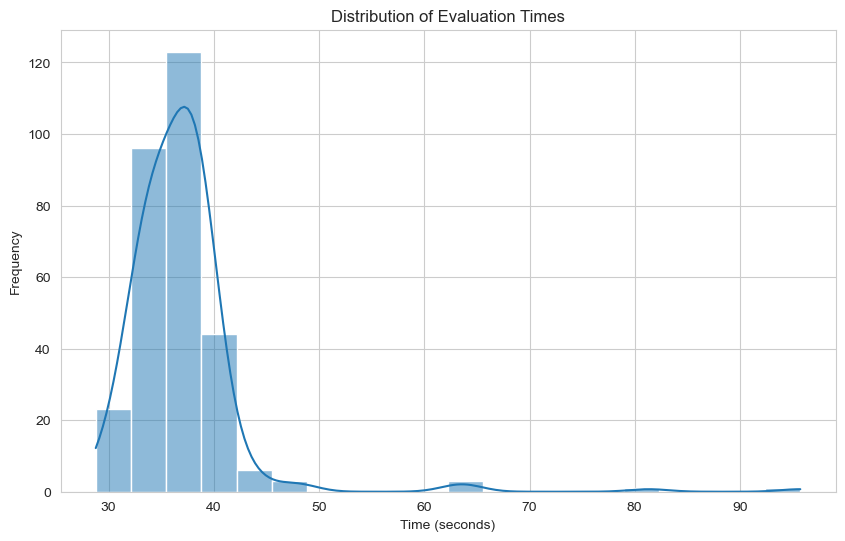

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of evaluation times
plt.figure(figsize=(10, 6))
sns.histplot(res['time_eval'], bins=20, kde=True)
plt.title('Distribution of Evaluation Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()

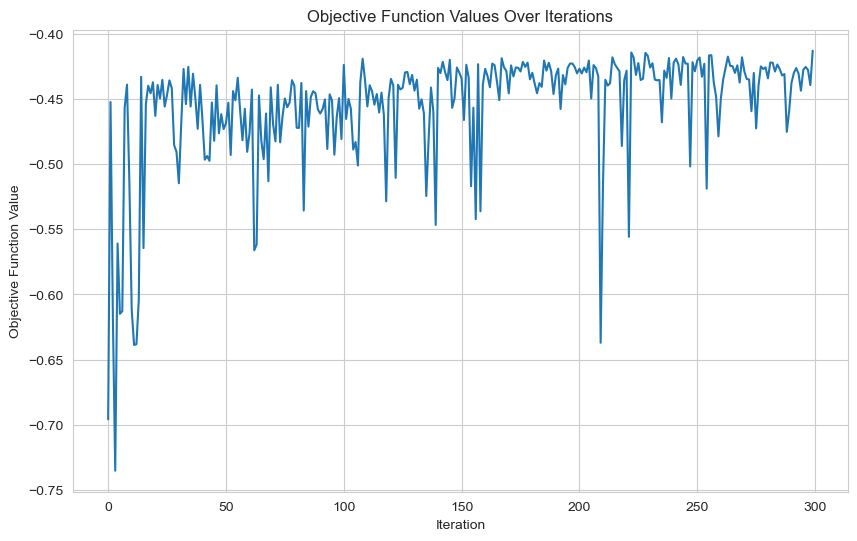

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(res['f_val'])
plt.title('Objective Function Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.show()

## Initialize BERTopic model to test the best parameters

In [37]:
from bertopic.representation import PartOfSpeech
# from bertopic.representation import PartOfSpeech
import bertopic as bt
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(
    # tokenizer=spacy_lemmatizer,
    stop_words="english",
    ngram_range=(1, 1))

# representation_model = MaximalMarginalRelevance(diversity=0.3)
# representation_model = PartOfSpeech(model='en_core_web_lg')
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=25, n_components=4, min_dist=0.188122, metric='euclidean', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

model = bt.BERTopic(verbose=True,
                    min_topic_size=37,
                    # nr_topics=529,
                    ctfidf_model=ctfidf_model,
                    calculate_probabilities=True,
                    umap_model=umap_model,
                    hdbscan_model=hdbscan_model,
                    embedding_model=embedding_model,
                    vectorizer_model=vectorizer_model,
                    # representation_model=representation_model,
                    )

topics, probs = model.fit_transform(data, embeddings)

2024-05-22 14:13:46,611 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-22 14:13:59,635 - BERTopic - Dimensionality - Completed ✓
2024-05-22 14:13:59,635 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-22 14:14:00,028 - BERTopic - Cluster - Completed ✓
2024-05-22 14:14:00,031 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-22 14:14:22,678 - BERTopic - Representation - Completed ✓


In [38]:
all_words = [word for words in dataset.get_corpus() for word in words]
bertopic_topics = [
    [vals[0] if vals[0] in all_words else all_words[0] for vals in model.get_topic(i)[:topk]] for i in
    range(len(set(topics)) - 1)]

print("brah", bertopic_topics)
output_tm = {"topics": bertopic_topics}

brah [['kinase', 'regulation', 'receptor', 'qsar', 'chembl', 'fingerprints', 'molecule', 'molecular', 'compounds', 'drug'], ['columns', 'classes', 'seed', 'uniformly', 'random', 'subsampling', 'arguments', 'indices', 'sampling', 'maximum'], ['binarized', 'nominal', 'lower', 'study', 'numeric', 'instances', 'life', 'binary', 'myth', 'feature'], ['bid', 'ask', 'price', 'time', 'close', 'lowest', 'hourly', 'historical', 'highest', 'end'], ['printer', 'network', 'nodes', 'blanket', 'degree', 'barley', 'mildew', 'discrete', 'average', 'node'], ['album', 'meta', 'images', 'image', 'plant', 'shot', 'url', 'textures', 'pixels', 'supplementary'], ['tls', 'disconnect', 'alert', 'cipher', 'spec', 'change', 'window', 'acknowledgement', 'flag', 'option'], ['house', 'square', 'housing', 'footage', 'property', 'sale', 'basement', 'avocado', 'feet', 'houses'], ['colinearity', 'collinearity', 'datasets', 'stochastic', 'gradient', 'nonlinear', 'robustness', 'input', 'times', 'degree'], ['breast', 'cance

In [39]:
objective_metric.score(output_tm)

coherence -0.003227651470063984 0.498386174264968 -0.6963800519318418
diversity 0.9630434782608696 0.9630434782608696 -0.037656719334167574
repetition penalty 0.0 0.0 -23.025850929940457
weighted_score -5.169805571400399


[-0.6963800519318418, -0.037656719334167574]

In [91]:
model.get_topic_info()

Topic  Count                                          Name  \
0      -1   1090              -1_electricity_life_file_nominal   
1       0     49              0_journal_publish_medicinal_qsbr   
2       1   1105      1_kinase_regulation_receptor_fingerprint   
3       2    108                    2_tls_disconnect_tcp_alert   
4       3     32             3_software_defect_halstead_module   
5       4    113               4_bayesian_network_printer_node   
6       5     22               5_barley_mildew_bayesian_winter   
7       6    272                         6_bid_ask_price_forex   
8       7     92                              7_equal_x_y_sort   
9       8     89       8_friedman_colinearity_add_collinearity   
10      9     40                      9_iris_sepal_petal_width   
11     10    305      10_sampling_subsampling_select_specified   
12     11    132                       11_player_team_win_game   
13     12     53               12_wine_chocolate_flavor_citric   
14     13     35          13_covid-19_case_vaccination_country   
15     14     27                     14_page_memory_run_kernel   
16     15     72                   15_credit_loan_card_payment   
17     16     75            16_customer_marketing_churn_client   
18     17     33                17_steel_temper_anneal_surface   
19     18     41                18_speech_vowel_acoustic_voice   
20     19     23          19_yeast_localization_promoter_inner   
21     20     83           20_expression_gene_microarray_tumor   
22     21     36           21_forest_tree_hillshade_wilderness   
23     22     43              22_breast_cancer_impedance_color   
24     23     51         23_particle_electron_cherenkov_shower   
25     24     29                 24_robot_torque_failure_force   
26     25     99                    25_car_vehicle_engine_fuel   
27     26     57                  26_heart_exercise_rest_chest   
28     27     52              27_diabetes_serum_blood_hospital   
29     28     27                 28_url_advertisement_click_ad   
30     29     59                29_bike_trip_airline_departure   
31     30     32             30_hate_transgender_vector_speech   
32     31    136              31_tweet_article_sentiment_movie   
33     32     20                32_turbine_gas_ambient_methane   
34     33     59  33_weather_climate_precipitation_temperature   
35     34    129                     34_meta_depth_bayes_naive   
36     35    115                     35_album_image_plant_meta   
37     36     34           36_digit_handwritten_character_omni   
38     37     59                37_student_school_grade_course   
39     38     67             38_libsvm_chemistry_life_chemical   
40     39     20          39_percentage_crime_immigrant_capita   
41     40     74               40_house_housing_footage_square   
42     41     32             41_income_survey_census_household   
43     42     21     42_excel_analcatdata_microsoft_backslashe   
44     43     69                 43_oz_nominal_binarize_oxygen   
45     44     63            44_binarize_binarized_oz_mythbuste   

                                                                                                   Representation  \
0                         [electricity, life, file, nominal, human, image, algae, study, smoothed, concentration]   
1                            [journal, publish, medicinal, qsbr, yokoyama, mtp, qsfsr, adriana, nineteen, garrat]   
2                            [kinase, regulation, receptor, fingerprint, qsar, chembl, couple, bit, g, molecular]   
3                                [tls, disconnect, tcp, alert, flag, cipher, window, spec, disc, acknowledgement]   
4                             [software, defect, halstead, module, line, cyclomatic, promise, code, nasa, effort]   
5                           [bayesian, network, printer, node, markov, blanket, bnlearn, degree, alarm, discrete]   
6                   [barley, mildew, bayesian, winter, malting, blanket, network, 

In [62]:
# optimization_result = optimizer.resume_optimization('./results/optimizer/result.json', extra_evaluations=5)

KeyError: 'WeightedMetric'

In [65]:
import pandas as pd

# Prepare data for boxplot
metrics = res['dict_model_runs']['Coherence']
iterations = list(metrics.keys())
values = [metrics[iter] for iter in iterations]
df = pd.DataFrame(values).T
df.columns = iterations

plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title('Distribution of Coherence Metric Values per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Coherence Metric Value')
plt.xticks(rotation=90)
plt.show()

KeyError: 'Coherence'

# Manual hyperparameter tuning

In [ ]:
for i in range(3):
    params = {
        "embedding_model": "all-mpnet-base-v2",
        # "nr_topics": [10, 20, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
        "nr_topics": [10, 20, 30, 50],
        # "min_topic_size": [2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
        "min_topic_size": [5],
        # "ctfidf_model": [ClassTfidfTransformer(), ClassTfidfTransformer(reduce_frequent_words=True)],
        # "umap_model": [UMAP(n_neighbors=2, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=25, n_components=5, min_dist=0.0, metric='cosine'),
        # UMAP(n_neighbors=2, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='euclidean'),
        # UMAP(n_neighbors=25, n_components=5, min_dist=0.0, metric='euclidean')
        # ],
        # "hdbscan_model": [
        #     HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
        # HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
        # HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
        # HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
        # HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
        # ],
        # 'vectorizer_model': [CountVectorizer(ngram_range=(1, 1), stop_words="english"),
        # CountVectorizer(ngram_range=(1, 2), stop_words="english"),
        # CountVectorizer(ngram_range=(1, 1), stop_words="english", tokenizer=spacy_lemmatizer),
        # CountVectorizer(ngram_range=(1, 2), stop_words="english", tokenizer=spacy_lemmatizer)
        # ],
        "verbose": True
    }

    trainer = Trainer(dataset=dataset_name,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddings,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"./results/basic/openml_mpnet/BERTopic_openml_mpnet_{i + 1}")


In [ ]:
embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
embeddings = np.load('embeddings_prompts.npy')

In [ ]:
for i in range(3):
    params = {
        "embedding_model": "Salesforce/SFR-Embedding-Mistral",
        "nr_topics": [10, 20, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
        "top_n_words": [2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
        "n_gram_range": [(1, 1), (1, 2)],
        "min_topic_size":,
    "verbose": True
    }

    trainer = Trainer(dataset=dataset,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddings,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"./evaluation/results/basic/BERTopic_openml_mistral_{i + 1}")